In [1]:
from Q_learning import *
import torch
from DQN import DQNAgent
import pickle


Word_set = cache(total_words=8885) # max count
# Reproducability
Word_set = sorted(Word_set)

class Hangman2:
    def __init__(self, word):
        self.word = word
        self.guessed_word = ["_"] * len(self.word)
        self.lives = 5
        self.guessed_letters = []

    def __str__(self):
        return " ".join(self.guessed_word)

    def guess(self, letter):
        if len(letter) != 1 or not letter.isalpha():
            return "Invalid input"

        letter = letter.lower()
        if letter in self.guessed_letters:
            return "Already guessed"

        self.guessed_letters.append(letter)
        if letter in self.word:
            for i, char in enumerate(self.word):
                if char == letter:
                    self.guessed_word[i] = letter
            return "Correct"
        else:
            self.lives -= 1
            return "Incorrect"

    def is_game_over(self):
        if "_" not in self.guessed_word:
            return "win"
        elif self.lives <= 0:
            return "lose"
        return None

    def get_state(self):
        return (self.guessed_word.copy(), self.guessed_letters.copy())


def evaluate_agent2(agent, games=10, word_set=Word_set):
    if word_set is None or len(word_set) < games:
        raise ValueError("Word set must contain at least as many words as games to play.")

    wins = 0
    total_lives_left = 0
    words_won = set()

    # Disable exploration for evaluation
    original_exploration = agent.exploration_rate
    agent.exploration_rate = 0

    # Verify Q-table is loaded
    if not agent.q_table:
        print("⚠️ WARNING: Q-table is empty!")
        return

    for game in range(games):
        word = word_set[game]
        hangman = Hangman2(word)

        while True:
            state = hangman.get_state()
            normalized_state = agent.normalize_state(state)

            action = agent.choose_action(normalized_state, hangman.guessed_letters)

            if action is None:
                break  # No valid actions left
            
            # Perform action
            _ = hangman.guess(action)  
            
            game_status = hangman.is_game_over()
            if game_status:
                if "win" in game_status:
                    wins += 1
                    total_lives_left += hangman.lives
                    words_won.add(hangman.word)
                break

    # Restore original exploration rate
    agent.exploration_rate = original_exploration

    # Summary
    win_rate = wins / games
    avg_lives = total_lives_left / wins if wins > 0 else 0

    print("\n🎯 Evaluation Results:")
    print(f"Games played: {games}")
    print(f"Games won: {wins}")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Average lives left (wins only): {avg_lives:.2f}")

    return list(words_won)



In [2]:
agent = Agent()

with open("q_table_huge.pkl", "rb") as f:
    agent.q_table = pickle.load(f)

evaluate_agent2(agent, games=100)


🎯 Evaluation Results:
Games played: 100
Games won: 31
Win rate: 31.00%
Average lives left (wins only): 3.55


['acerb',
 'aglee',
 'acred',
 'adobo',
 'adore',
 'afore',
 'afire',
 'agama',
 'acned',
 'afoot',
 'acres',
 'agger',
 'adder',
 'adzed',
 'achoo',
 'agers',
 'aeons',
 'agene',
 'added',
 'aegis',
 'adage',
 'aedes',
 'aglow',
 'after',
 'acold',
 'acock',
 'adieu',
 'ackee',
 'aerie',
 'adeem',
 'aghas']

A 600 mb file of dictionary of Q-values provide not so compelling results.

Lets instead try a more traditional way of solving this

In [3]:
def remove_words(incorrect_letter, word_list):
    return [word for word in word_list if incorrect_letter not in word]

from functools import lru_cache
import re

@lru_cache(maxsize=None)
def pattern_from_guess(guessed_word):
    return re.compile('^' + ''.join('.' if c == '_' else c for c in guessed_word) + '$')

def keep_words(guessed_word, word_list):
    # Convert to string if it's a list of characters
    if isinstance(guessed_word, list):
        guessed_word = ''.join(guessed_word)

    pattern = pattern_from_guess(guessed_word)
    return [word for word in word_list if pattern.match(word)]


def most_common_letter(word_list, guessed_words):
    dictionary = {}
    for word in word_list:
        for letter in word:
            if letter in dictionary:
                dictionary[letter] += 1
            else:
                dictionary[letter] = 1

    for item in guessed_words:
        dictionary[item] = 0

    return max(dictionary, key=dictionary.get)

In [4]:
def evaluate_agent_simple(games=10, word_set=Word_set):
    if word_set is None or len(word_set) < games:
        raise ValueError("Word set must contain at least as many words as games to play.")

    wins = 0
    total_lives_left = 0
    words_won = set()

    for game in range(games):
        word = word_set[game]
        hangman = Hangman2(word)
        curr_word_set = word_set
        incorrect_letters = None
        while True:
            guessed_letters = hangman.guessed_letters
            guessed_word = hangman.guessed_word
    
            # Convert guessed_letters to a set once for fast lookup
            guessed_letters_set = set(guessed_letters)

            # Choose next best letter to guess
            action = most_common_letter(curr_word_set, guessed_letters_set)
            
            move = hangman.guess(action)

            game_status = hangman.is_game_over()
            if game_status:
                if "win" in game_status:
                    wins += 1
                    total_lives_left += hangman.lives
                    words_won.add(hangman.word)
                break


            if move == "incorrect":
                incorrect_letters = action
            else:
                # Apply filters to reduce the word set efficiently
                curr_word_set = keep_words(guessed_word, curr_word_set)

            if incorrect_letters:
                curr_word_set = remove_words(incorrect_letters, curr_word_set)

            if not action or not curr_word_set:
                print(f"action: {action}, Curr_word_set: {curr_word_set}")
                break



    # Summary
    win_rate = wins / games
    avg_lives = total_lives_left / wins if wins > 0 else 0

    print("\n🎯 Evaluation Results:")
    print(f"Games played: {games}")
    print(f"Games won: {wins}")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Average lives left (wins only): {avg_lives:.2f}")

    return list(words_won)



In [5]:
agent_dqn = DQNAgent()
agent_dqn.model.load_state_dict(torch.load("dqn_hangman.pt"))
                            
def evaluate_dqn_agent(agent, games=10, word_set=Word_set):
    if word_set is None or len(word_set) < games:
        raise ValueError("Word set must contain at least as many words as games to play.")
    words_won = set()
    wins = 0
    total_lives_left = 0

    for i in range(games):
        target_word = word_set[i]
        hangman = Hangman2(target_word)

        while True:
            guessed_word, guessed_letters = hangman.get_state()
            state_tensor = agent.state_to_tensor(guessed_word, guessed_letters, hangman.lives)
            action = agent.choose_action(state_tensor, guessed_letters)

            if not action:
                break  # No valid action left

            hangman.guess(action)
            game_status = hangman.is_game_over()

            if game_status:
                if game_status == "win":
                    wins += 1
                    total_lives_left += hangman.lives
                    words_won.add(hangman.word)
                break

    # Print results
    win_rate = wins / games
    avg_lives = total_lives_left / wins if wins > 0 else 0

    print("\n🎯 DQN Evaluation Results")
    print(f"Games played: {games}")
    print(f"Wins: {wins}")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Avg lives left (wins only): {avg_lives:.2f}")

    return list(words_won)


In [6]:
simple_words = evaluate_agent_simple(games=8885)


🎯 Evaluation Results:
Games played: 8885
Games won: 3507
Win rate: 39.47%
Average lives left (wins only): 2.19


In [7]:
Q_agent = evaluate_agent2(agent, games=8885)


🎯 Evaluation Results:
Games played: 8885
Games won: 901
Win rate: 10.14%
Average lives left (wins only): 3.06


In [8]:
DQN_agent = evaluate_dqn_agent(agent_dqn, games=8885)


🎯 DQN Evaluation Results
Games played: 8885
Wins: 150
Win rate: 1.69%
Avg lives left (wins only): 2.05


In [9]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


def split_dataframe(word_list, name):

    all_letters = list("".join(word_list))

    letter_counts = Counter(all_letters)

    # Create DataFrame
    df = pd.DataFrame(letter_counts.items(), columns=["Letter", "Count"])
    df = df.sort_values(by="Count", ascending=False)

    # Visualize
    plt.figure(figsize=(8, 5))
    plt.bar(df["Letter"], df["Count"], color="mediumpurple")
    plt.xlabel("Letters")
    plt.ylabel("Frequency")
    plt.title(f"Letter Frequency in: {name}")
    plt.tight_layout()
    plt.show()

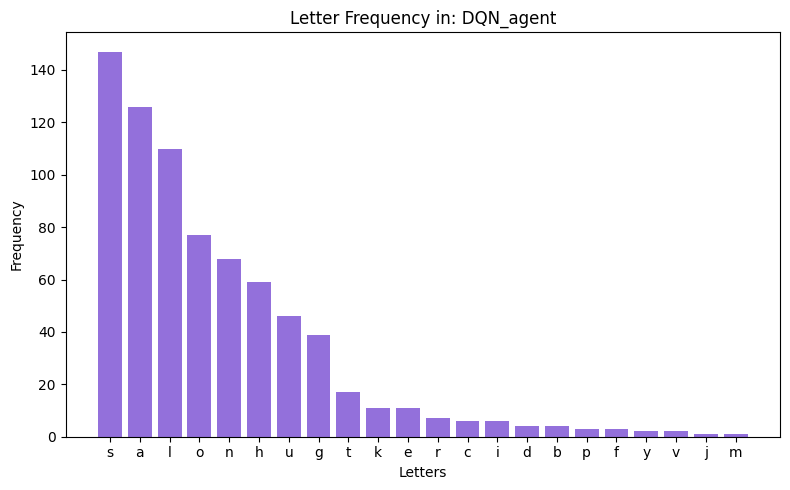

In [10]:
split_dataframe(DQN_agent, "DQN_agent")

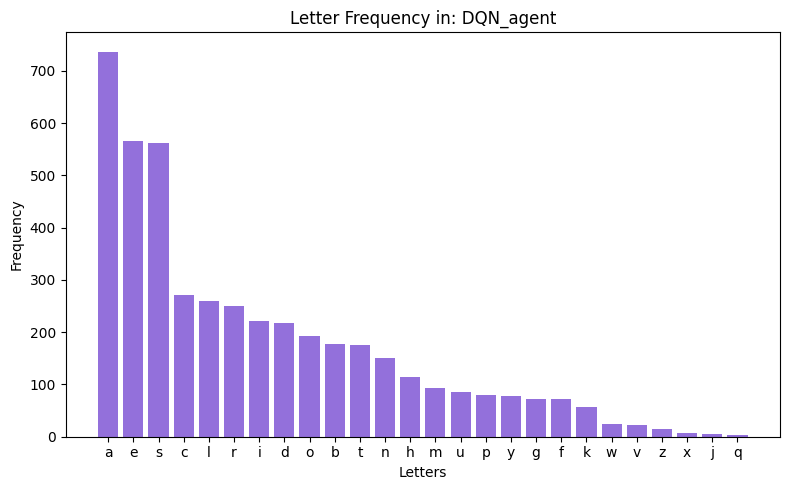

In [11]:
split_dataframe(Q_agent, "DQN_agent")

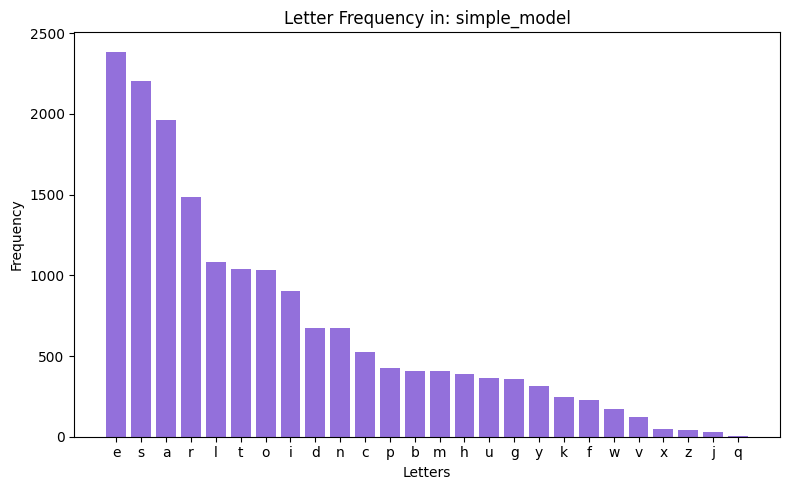

In [12]:
split_dataframe(simple_words, "simple_model")

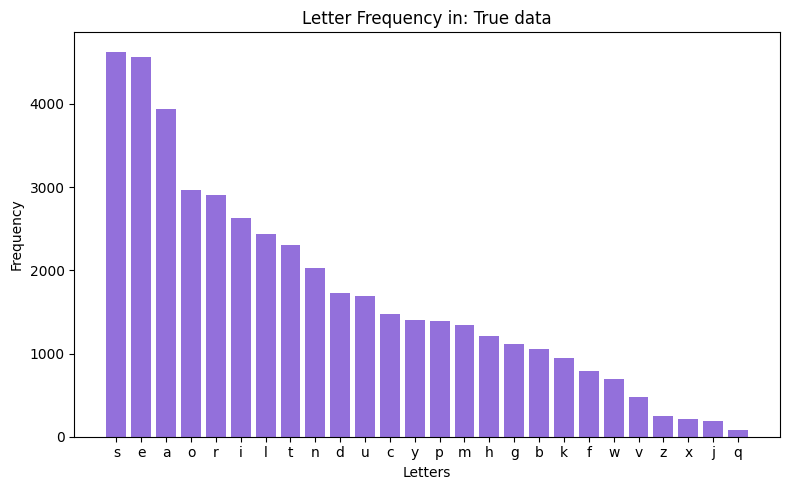

In [13]:
split_dataframe(Word_set, "True data")

Our data is without a doubt skewed. DQN is a very terrible model in this case mainly because of the sparse rewards. Q-table did well, however more traditional method worked even better(who would have gussed).